In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

train_data = pd.read_csv('../data/balanced_train.csv')
test_data = pd.read_csv('../data/balanced_test.csv')

genre_columns = train_data.columns.drop(['Name', 'Description Tokenized'])

# Tokenizar os textos
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(train_data['Description Tokenized']) + list(test_data['Description Tokenized']))
word_index = tokenizer.word_index
num_words = len(word_index) + 1

X_train = tokenizer.texts_to_sequences(train_data['Description Tokenized'])
X_test = tokenizer.texts_to_sequences(test_data['Description Tokenized'])

maxlen = max(max([len(sequence) for sequence in X_train]), max([len(sequence) for sequence in X_test]))

# Padronizar os textos
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

#labels one-hot encoded
y_train = train_data[genre_columns].values
y_test = test_data[genre_columns].values


# 2. Construir o modelo
embedding_dim = 128  # Dimensão do vetor de embedding
lstm_units = 128  # Unidades LSTM

model = Sequential([
    Embedding(num_words, embedding_dim, input_length=maxlen),
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    Dropout(0.25),
    Bidirectional(LSTM(lstm_units)),
    Dense(len(genre_columns), activation='sigmoid')
])

# 3. Treinar o modelo
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

batch_size = 32
epochs = 15

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# 4. Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

Epoch 1/15
144/144 [==============================] - 117s 513ms/step - loss: 0.5365 - accuracy: 0.2893 - val_loss: 0.4618 - val_accuracy: 0.3887
Epoch 2/15
144/144 [==============================] - 36s 251ms/step - loss: 0.4088 - accuracy: 0.3701 - val_loss: 0.4050 - val_accuracy: 0.3770
Epoch 3/15
144/144 [==============================] - 32s 225ms/step - loss: 0.2829 - accuracy: 0.4235 - val_loss: 0.3999 - val_accuracy: 0.3711
Epoch 4/15
144/144 [==============================] - 33s 226ms/step - loss: 0.1919 - accuracy: 0.4719 - val_loss: 0.4180 - val_accuracy: 0.4141
Epoch 5/15
144/144 [==============================] - 30s 209ms/step - loss: 0.1325 - accuracy: 0.4840 - val_loss: 0.4562 - val_accuracy: 0.3984
Epoch 6/15
144/144 [==============================] - 32s 223ms/step - loss: 0.0955 - accuracy: 0.4849 - val_loss: 0.5036 - val_accuracy: 0.4121
Epoch 7/15
144/144 [==============================] - 35s 244ms/step - loss: 0.0690 - accuracy: 0.5034 - val_loss: 0.5556 - val_a

In [2]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_binarized = np.round(y_pred)


report = classification_report(y_test, y_pred_binarized, target_names=genre_columns, zero_division=0)
print(report)

40/40 [==============================] - 7s 135ms/step
                         precision    recall  f1-score   support

                 Comedy       0.72      0.69      0.71       487
                  Crime       0.73      0.85      0.78       271
                  Drama       0.75      0.74      0.75       613
                Romance       0.72      0.66      0.69       270
   Action and Adventure       0.78      0.75      0.76       463
Documentary and History       0.77      0.65      0.70       172
   Family and Animation       0.76      0.73      0.74       275
     Fantasy and Sci-Fi       0.73      0.75      0.74       259
    Horror and Thriller       0.68      0.69      0.68       309

              micro avg       0.74      0.73      0.73      3119
              macro avg       0.74      0.72      0.73      3119
           weighted avg       0.74      0.73      0.73      3119
            samples avg       0.72      0.71      0.70      3119



In [3]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

y_pred_prob = model.predict(X_test)

pr_curves = {}
roc_curves = {}
for i, genre in enumerate(genre_columns):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_prob[:, i])
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    pr_curves[genre] = (precision, recall)
    roc_curves[genre] = (fpr, tpr)
    
auc_pr = []
auc_roc = []
for i, genre in enumerate(genre_columns):
    ap = auc(pr_curves[genre][1], pr_curves[genre][0])
    ar = auc(roc_curves[genre][0], roc_curves[genre][1])
    auc_pr.append(ap)
    auc_roc.append(ar)

results = pd.DataFrame({'genre': genre_columns, 'AUC-PR': auc_pr, 'AUC-ROC': auc_roc})
print(results)



40/40 [==============================] - 5s 124ms/step
                     genre    AUC-PR   AUC-ROC
0                   Comedy  0.687663  0.824211
1                    Crime  0.772607  0.923771
2                    Drama  0.754272  0.822641
3                  Romance  0.709588  0.861802
4     Action and Adventure  0.778638  0.862612
5  Documentary and History  0.720831  0.925116
6     Family and Animation  0.752099  0.895280
7       Fantasy and Sci-Fi  0.754124  0.901191
8      Horror and Thriller  0.667975  0.862258


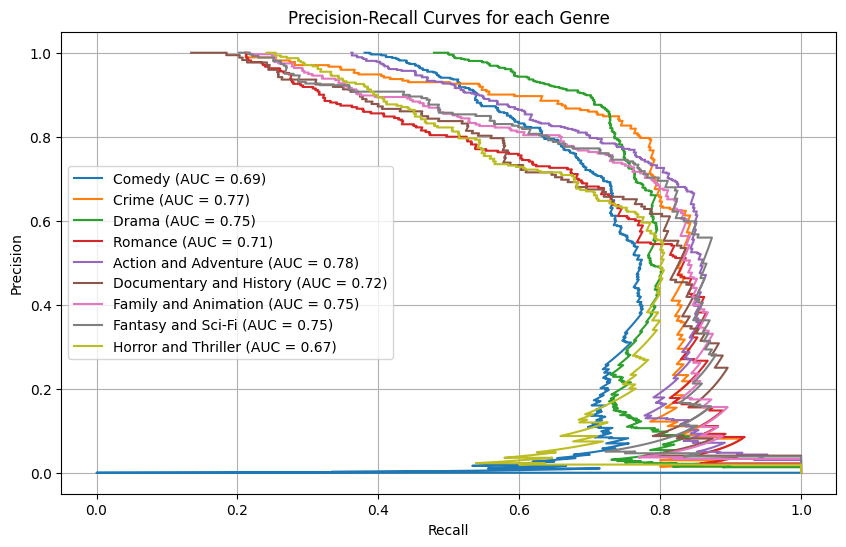

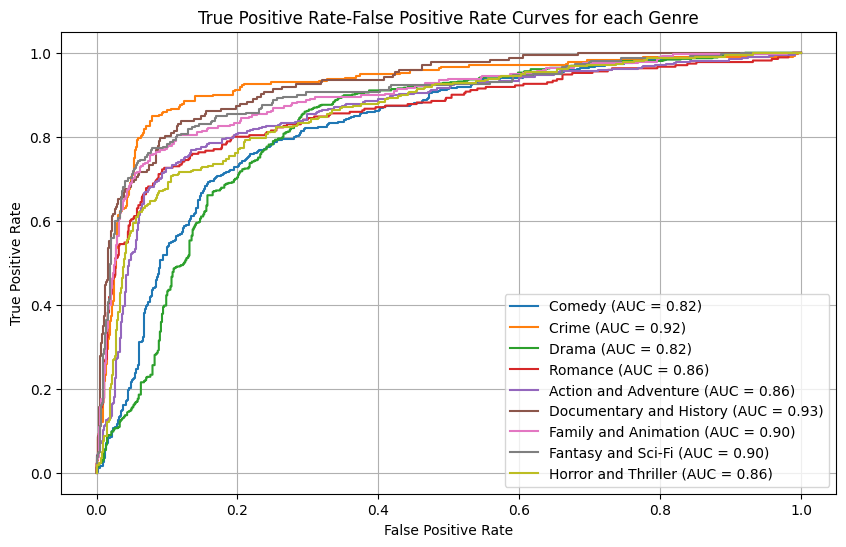

In [4]:
import matplotlib.pyplot as plt

def plot_curves(curves, curve_type, metric_name):
    plt.figure(figsize=(10, 6))
    for genre in curves.keys():
        x, y = curves[genre]
        if metric_name == 'AUC-PR':
            auc_value = auc(y, x)  # Use recall (y) as x and precision (x) as y
        else:
            auc_value = auc(x, y)  # Use FPR (x) as x and TPR (y) as y

        plt.plot(x, y, label=f'{genre} (AUC = {auc_value:.2f})')

    plt.xlabel(curve_type[0])
    plt.ylabel(curve_type[1])
    plt.title(f'{curve_type[1]}-{curve_type[0]} Curves for each Genre')
    plt.legend(loc='best')
    plt.grid()

plot_curves(pr_curves, ('Recall', 'Precision'), 'AUC-PR')
plt.show()

plot_curves(roc_curves, ('False Positive Rate', 'True Positive Rate'), 'AUC-ROC')
plt.show()

In [5]:
from sklearn.metrics import confusion_matrix

# Obter as previsões do modelo
y_pred_binarized = np.round(model.predict(X_test))

# Calcular a matriz de confusão para cada classe
for i, genre in enumerate(genre_columns):
    cm = confusion_matrix(y_test[:, i], y_pred_binarized[:, i])
    print(f'Confusion matrix for {genre}:')
    print(cm)
    print('------------------------')

40/40 [==============================] - 5s 126ms/step
Confusion matrix for Comedy:
[[661 132]
 [149 338]]
------------------------
Confusion matrix for Crime:
[[924  85]
 [ 41 230]]
------------------------
Confusion matrix for Drama:
[[517 150]
 [157 456]]
------------------------
Confusion matrix for Romance:
[[941  69]
 [ 91 179]]
------------------------
Confusion matrix for Action and Adventure:
[[719  98]
 [118 345]]
------------------------
Confusion matrix for Documentary and History:
[[1074   34]
 [  60  112]]
------------------------
Confusion matrix for Family and Animation:
[[941  64]
 [ 75 200]]
------------------------
Confusion matrix for Fantasy and Sci-Fi:
[[948  73]
 [ 64 195]]
------------------------
Confusion matrix for Horror and Thriller:
[[869 102]
 [ 95 214]]
------------------------
